In [1]:
import json

with open('labels_map.txt', 'r') as f:
    label_map = {int(k): v for k, v in json.load(f).items()}

print(label_map)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

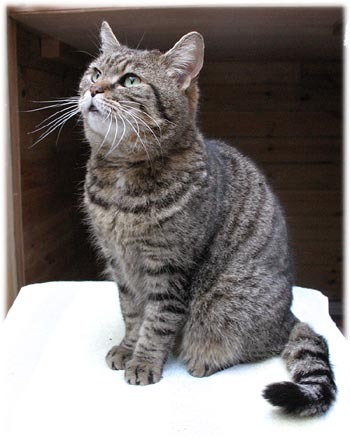

In [2]:
from PIL import Image

image = Image.open("input_img/tabby_cat.jpg")
display(image)

### Prepare a model: PyTorch-fp32 (Original)

In [3]:
from efficientnet_pytorch import EfficientNet as enet

modelver = ('b0', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7')[0]
model = enet.from_pretrained(f'efficientnet-{modelver}')
model = model.cuda()

/home/ircv2/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded pretrained weights for efficientnet-b0


### Prepare an input image

In [4]:
from torchvision import transforms as tf

INPUT_IMAGE_SIZE = 224

img_transforms = tf.Compose([
    tf.Resize(INPUT_IMAGE_SIZE),
    tf.CenterCrop(INPUT_IMAGE_SIZE),
    tf.ToTensor(),
    tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

input_img = img_transforms(image).unsqueeze(0)

## 1. Inference
### A. PyTorch-FP32 model

In [5]:
import time
import torch

model.eval()
with torch.no_grad():

    # warmup
    input_img_cuda = input_img.cuda()
    dummy = torch.randn_like(input_img_cuda)
    for _ in range(10):
        model(dummy)

    t_start = time.time()
    results = model(input_img_cuda)
    t_end = time.time()

t_inference_pytorch_fp32 = t_end - t_start
print(f"Model Inference Time (PyTorch-fp32): {t_inference_pytorch_fp32 * 1000:.2f}ms")

Model Inference Time (PyTorch-fp32): 31.54ms


### Visualize predictions

tabby, tabby cat                                                            (59.19%)
tiger cat                                                                   (10.89%)
Egyptian cat                                                                (10.33%)


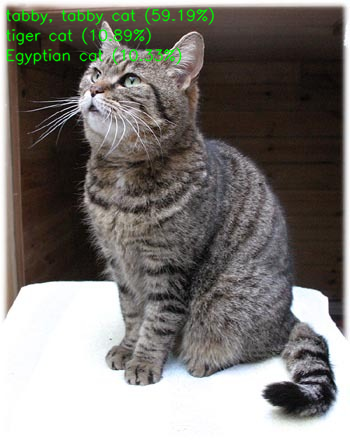

In [6]:
import cv2
import numpy as np

def show_predictions(image, results, label_map):
    preds = torch.topk(results, k=3).indices.squeeze(0).tolist()
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontscale = 0.5
    color=(0, 255, 0)
    thick = 1
    image_np = np.array(image)

    for cnt, idx in enumerate(preds):
        label = label_map[idx]
        prob = torch.softmax(results, dim=1)[0, idx]
        text = f'{label} ({(prob*100):.2f}%)'
        position = (5,20 + cnt*20)
        cv2.putText(image_np, text, position, font, fontscale, color, thick, cv2.LINE_AA)
        print(f'{label:<75} ({(prob*100):.2f}%)')
    return image_np

Image.fromarray(show_predictions(image, results, label_map))

### Profiling

In [7]:
import torch.autograd.profiler as profiler

with profiler.profile(with_stack=True, use_cuda=True, profile_memory=True) as prof:
    results = model(input_img.cuda())
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                    aten::conv2d         1.96%       1.792ms        34.61%      31.659ms     390.852us       1.857ms         1.81%      42.413ms     523.617us           0 b           0 b      25.98 Mb           0 b            81  
               aten::convolution         4.18%       3.821ms        32.65%

# Embedded AI: An efficient inference

### Build: PyTorch model -> ONNX model

In [8]:
import os
os.makedirs('models', exist_ok=True)

onnx_filename = f"models/efnet-{modelver}.onnx"
if not os.path.exists(onnx_filename):
    print("Building ONNX & TensorRT model\nThis will take about 10 min or more")
    dummy_input = torch.randn(1, 3, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
    model.set_swish(memory_efficient=False)
    torch.onnx.export(model, dummy_input, onnx_filename, verbose=True)

### Build: ONNX model -> TensorRT model (FP32)

In [9]:
from onnx_trt import convert_trt, ONNXClassifierWrapper

### fp32
trt_filename = f'models/trt_{modelver}_fp32.engine'
if not os.path.exists(trt_filename):
    convert_trt(onnx_filename, trt_filename, half=False)

batch_size = 1
num_classes = len(label_map)
model = ONNXClassifierWrapper(
            trt_filename,
            [batch_size, num_classes],
            target_dtype = np.float32)


In [10]:
input_img_np = input_img.numpy().transpose((0,3,2,1))

dummy = np.random.randn(*input_img_np.shape).astype(np.float32)
for _ in range(10):
    model.predict(dummy)

t_inference_trt_fp32, results = model.predict(input_img_np, eval_exec_time=True)
results = torch.from_numpy(results)

print(f"Model Inference Time (PyTorch-fp32): {t_inference_pytorch_fp32 * 1000:.2f}ms")
print(f"Model Inference Time (TensorRT-fp32): {t_inference_trt_fp32 * 1000:.2f}ms")

Model Inference Time (PyTorch-fp32): 31.54ms
Model Inference Time (TensorRT-fp32): 1.83ms


### Build: ONNX model -> TensorRT model (FP16)

In [11]:
### fp16
trt_filename = f'models/trt_{modelver}_fp16.engine'
if not os.path.exists(trt_filename):
    convert_trt(onnx_filename, trt_filename, half=True)

batch_size = 1
num_classes = len(label_map)
model = ONNXClassifierWrapper(
            trt_filename,
            [batch_size, num_classes],
            target_dtype = np.float32)


In [12]:
dummy = np.random.randn(*input_img_np.shape).astype(np.float32)
for _ in range(10):
    model.predict(dummy)

t_inference_trt_fp16, results = model.predict(input_img_np, eval_exec_time=True)

results = torch.from_numpy(results)

print(f"Model Inference Time (PyTorch-fp32): {t_inference_pytorch_fp32 * 1000:.2f}ms")
print(f"Model Inference Time (TensorRT-fp32): {t_inference_trt_fp32 * 1000:.2f}ms")
print(f"Model Inference Time (TensorRT-fp16): {t_inference_trt_fp16 * 1000:.2f}ms")

Model Inference Time (PyTorch-fp32): 31.54ms
Model Inference Time (TensorRT-fp32): 1.83ms
Model Inference Time (TensorRT-fp16): 1.12ms


# Summary: Draw a graph

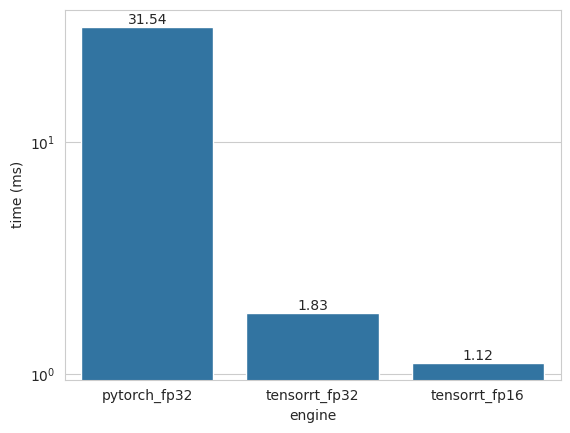

In [13]:
import seaborn as sns
import pandas as pd

time_ms = [
    t_inference_pytorch_fp32 * 1000,
    t_inference_trt_fp32 * 1000,
    t_inference_trt_fp16 * 1000,
]
engine = ['pytorch_fp32', 'tensorrt_fp32', 'tensorrt_fp16']
df = pd.DataFrame(data={'time (ms)': time_ms, 'engine': engine})

sns.set_style('whitegrid')
ax = sns.barplot(df, x='engine', y='time (ms)')
ax.bar_label(ax.containers[0], fontsize=10, fmt="%.2f")
ax.set_yscale('log')